[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW3/AIPI590_MLCourt.ipynb)

# 👩‍⚖️ ⚖️ AIPI 590: Machine Learning Court

Rebecca Du (rrd17)

This notebook provides base model training code for the case scenario below:
-  **Recidivism Prediction**

**Assigned Side**: Case 3 Recidivism, Prosecution





## 1) ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

In [1]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [2]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]


## 2) Local Explainability Techniques Selection

We have learned multiple local explainability techniques, including LIME, Anchors, SHAP, and ICE plots.

For the purpose of this assignment, the techniques I have chosen to bolster the prosecution's argument are:

1. **SHAP (SHapley Additive Explanations)**: using SHAP, we can specifically quantify how much each feature contributed to calculating Malik's recidivism risk.

2. **ICE (Individual Conditional Expectation) Plots**: using ICE, we can aassess how the predicted recidivism risk would change if one feature was altered while others were held constant.

## 3) SHAP (SHapley Additive Explanations)

SHAP stands for SHapley Additive exPlanations and was first introduced in [2017](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf). The concept originates from coalitional game theory, and when applied to machine learning, helps allocate predictive power to the features of an instance.

To use SHAP, we must make a background distribution, which acts as a baseline to compare how much each feature influences prediction.

To help us understand SHAP, we will make the following visualizations:
1. **SHAP Summary Plot**
2. **SHAP Waterfall Plot**
3.  **SHAP Dependence Plots**

### 3.1) SHAP Summary Plot

100%|===================| 2872/2886 [02:22<00:00]       

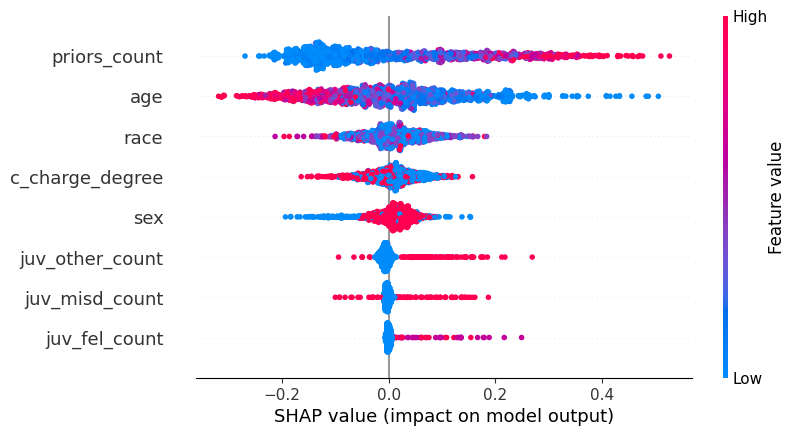

In [9]:
import shap

#Get background dataset
X_bg = shap.utils.sample(X_train, 100, random_state=42)

#Make TreeExplainer
explainer = shap.TreeExplainer(model_compas, X_bg)
shap_exp = explainer(X_test)

#Get class index for recidivism
class_idx = list(model_compas.classes_).index(1)

#Start of code generated using GPT-5 on 9/18/2025 at 7:47 PM
exp_cls1 = shap.Explanation(
    values       = shap_exp.values[..., class_idx],
    base_values  = shap_exp.base_values[..., class_idx],
    data         = shap_exp.data,
    feature_names= X_test.columns,
) #End of generated code

#Plot
shap.plots.beeswarm(exp_cls1, max_display=10)


- **SHAP Summary Plot**: in this plot, each dot represents one person and the x-axis represents how much one feature caused the individual to be categorized as higher risk (right) or lower risk (left).
    - *priors_count* has a significant impact and mostly causes individuals to be pushed towards the right and categorized as higher risk.
    - *age* mostly pushes left, making individuals with high age classified as lower risk.
    - *race* and *c_charge_degree* have small positive effects that cause slightly increased risk in recidivism.
    - *sex* and *juv_counts* have minimal impact

In short, the summary plot marks individuals that have **more priors, are younger, and of a certain race** as having higher predicted risk.

### 3.2) SHAP Waterfall Plot

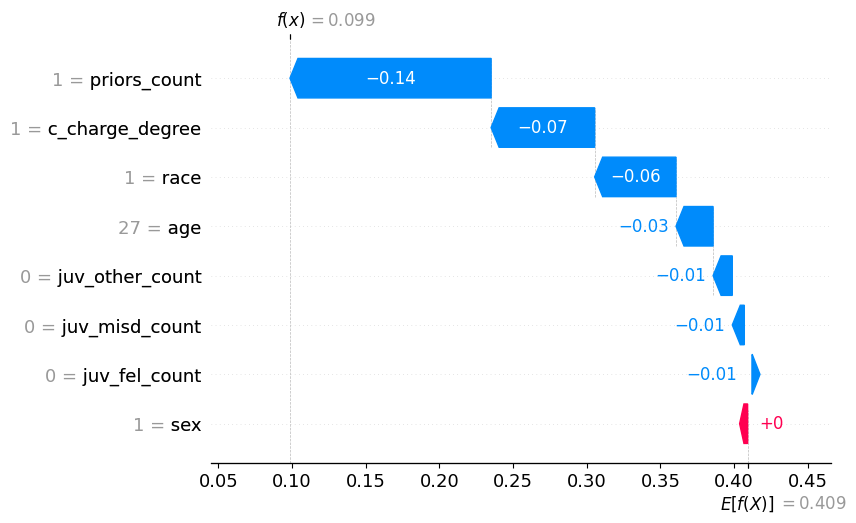

In [11]:
#Plots for focus instance: Malik
shap_exp_malik = explainer(focus_instance_compas)
exp_focus1 = shap.Explanation(
    values       = shap_exp_malik.values[..., class_idx],
    base_values  = shap_exp_malik.base_values[..., class_idx],
    data         = shap_exp_malik.data,
    feature_names= X_test.columns,
)

#Plot
shap.plots.waterfall(exp_focus1[0])

- **SHAP Waterfall Plot (Focus Instance: Malik)**: this graph shows how each feature contributes to Malik's prediction for recidivism.
  - *Prior_count = 1* lowers the probability, indicating that having low prior counts reduces risk.
  - *c_charge_degree = 1* Malik's combination of features causes the degree of the charge to lower the risk compared to the global average.
  - *race = 1* and *age = 27* both have small impact in decreasing risk

Compared to the 41% recidivisim baseline, Malik's low priors combined with his other features cause the model to predict him as only having a 10% risk.

### 3.3) SHAP Dependence Plots

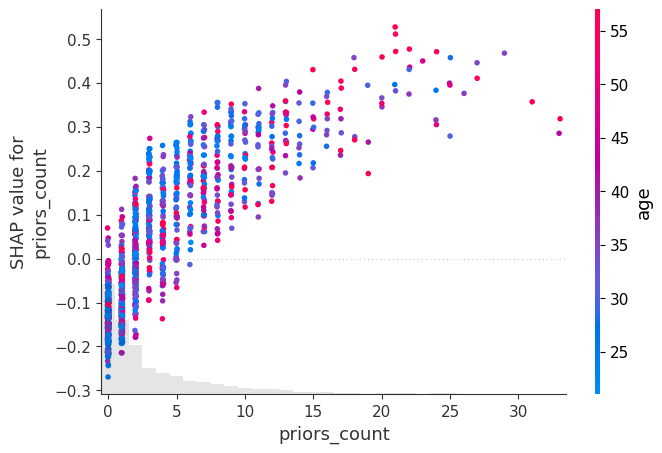

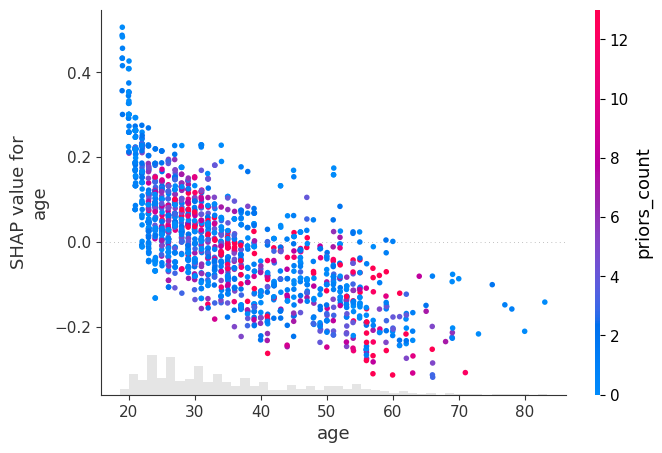

In [12]:
#Dependence plots
#How risk changes with priors
shap.plots.scatter(exp_cls1[:, "priors_count"], color=exp_cls1[:, "age"])

#How risk changes with age
shap.plots.scatter(exp_cls1[:, "age"], color=exp_cls1[:, "priors_count"])

- **SHAP Dependence: priors_count by age**:
  - This plot lets us see the effect of priors on risk
  - For the most part, having more priors leads to higher risk


- **SHAP Dependence: age by priors_count**:
  - This plot lets us see the effect of age on risk
  - There is a noticeable downward slope: older individuals are less likely to be high risks
  - However, individuals with more priors (regardless of age) are still marked as higher risk

From this, we conclude that priors amplify risk at every age.

### 3.4) SHAP Bar Chart

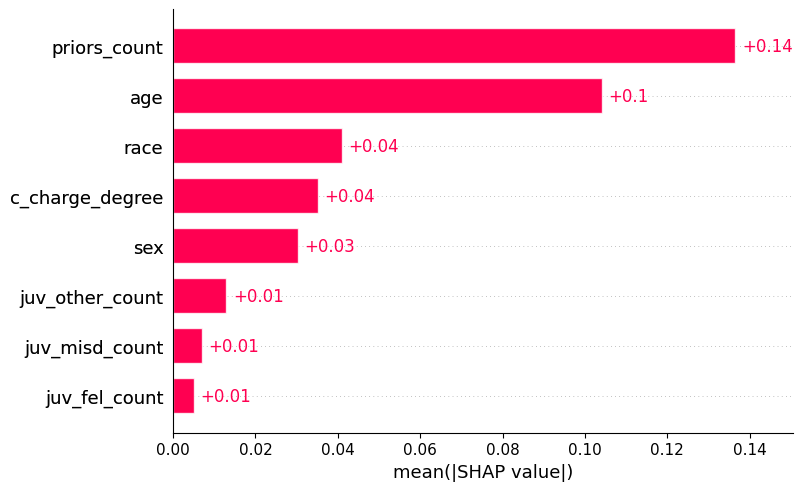

In [13]:
shap.plots.bar(exp_cls1, max_display=10)

- **SHAP Bar Chart**: from this, we can see that the greatest contributors to risk prediction are *priors_count* and *age*

## 4) ICE Plots

Individual Conditional Expectation (ICE) plots include one line for each instance, and they display how the instance's prediction changes when a feature's value is altered.

The steps are as follows:
1. Choose an instance and a feature of interest
2. Holding all other features constant, we create variants of the instance by replacing the feature's value with values from a grid
3. We then make predictions with the black box model for new instances and plot them.

We will plot 2 ICE Plots for Malik:
1. Varying priors_count
2. Varying age

In [23]:
def ice_plot_malik(model, X_ref, malik_df, feature_name, class_value=1, num=50):
  # Choose instance (Malik) and feature by index
  feature_index = X_ref.columns.get_loc(feature_name)

  instance = malik_df[X_ref.columns].iloc[[0]]

  #Create grid
  col = X_ref.iloc[:, feature_index]
  if pd.api.types.is_integer_dtype(col) or col.nunique() <= num:
      lo, hi = int(col.min()), int(col.max())
      feature_values = np.arange(lo, hi + 1)
  else:
      lo, hi = col.quantile(0.01), col.quantile(0.99)
      feature_values = np.linspace(lo, hi, num=num)

  #Initialize array to store predictions
  average_predictions = np.zeros_like(feature_values, dtype=float)

  #Duplicate the instance to modify feature values
  instance_modified = instance.copy()

  #Determine which column of predict_proba corresponds to class_value
  class_idx = list(model.classes_).index(class_value)

  #Loop over feature values
  for i, value in enumerate(feature_values):
    #Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    #Predict using the modified instance
    prediction = model.predict_proba(instance_modified)[:, class_idx]

    #Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

  # Plot the ICE plot
  plt.figure()
  plt.plot(feature_values, average_predictions, linewidth=2)
  plt.xlabel(feature_name)  # 'Feature values'
  plt.ylabel(f'Predicted probability of class {class_value}')
  plt.title(f'ICE Plot - {feature_name} (Malik)')
  # Mark Malik’s original value for context
  orig_val = instance.iloc[0, feature_index]
  orig_pred = model.predict_proba(instance)[:, class_idx].item()
  plt.axvline(orig_val, linestyle='--', alpha=0.6)
  plt.scatter([orig_val], [orig_pred], s=40)
  plt.axhline(0.5, linestyle=':', alpha=0.5)
  plt.show()

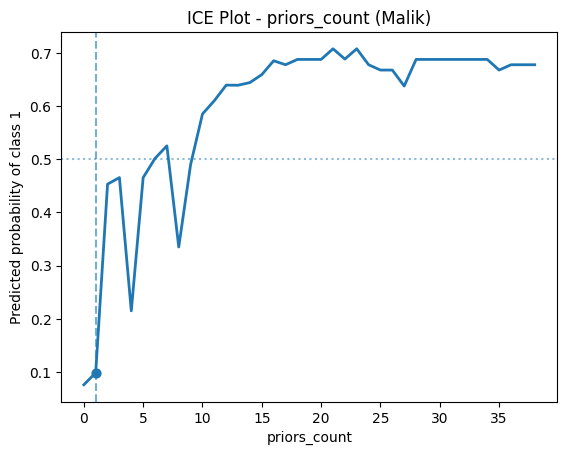

In [24]:
#Plot priors_count
ice_plot_malik(model_compas, X_train, focus_instance_compas, 'priors_count')


- **ICE Plot - Priors_Count**:
  - From the shape, we can see that there is a sharp increase from 0-5 priors. Although the trend continues upwards, it begins to plateau
  - There is a higher sensitivity to priors increasing recidivism risk for earlier prior counts.
  - Malik's current predicted recidivism risk is plotted as the blue point
  - The horizontal line marks the point above which individuals would be considered 'high risk'
    - For Malik, he would need around 9-11 priors to become a high risk individual

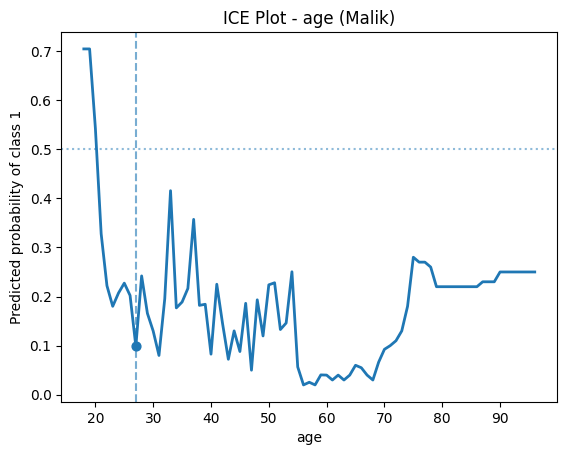

In [25]:
#Plot age
ice_plot_malik(model_compas, X_train, focus_instance_compas, 'age')

- **ICE Plot - Age**:
  - There is a noticeable downward trend for the most part, demonstrating that as Malik becomes older, his predicted risk will decrease drastically until 70.
  - Again, the blue dot represents where Malik currently is.
  - Only at young ages would Malik's risk of recidivism be increased due to his age.
  - Thus, it is safe to say that older age tends to lower risk.

## 5) Prosecution Argument

1. **ICE Plots**:
    - In the ICE plot for *priors_count*, there is a sharp jump from 0-5 priors, which would cause Malik's risk probability to increase from 10% to 45%
    - Thus, this demonstrates that the prediction is very sensitive to changes near Malik's current prior amount (1).
      - Any re-offenses or other negative factors would effectively push him over the threshold and make him a categorically risky person.
      - **This high sensitivity means that we shouldn't trust a low-end estimate of risk since it is easily variable.**

2. **SHAP Plots**:
    - From the entire dataset, we can see that *c_charge_degree* and *race* tend to cause risk to increase.
    - However, for Malik, these actually help decrease his risk.
    - Thus, Malik appears to be inconsistent with the rest of the data.
      - This can be attributed to the model having label-encoded categoricals, which is insufficient to draw strong causality.
      - Re-encoding the model will likely cause Malik's probability of recidivism to increase.

3. **Strongest Predictors Work Against Malik**:
    - The two strongest predictors of increased risk are **high priors_count and young/low age**
    - Malik is 27, which is relatively young compared to the points in the data
      - Though risk eventually decreases with age, he is not yet at the point where he can comfortably be considered not at high risk of recidivism.
    - Furthermore, he already has 1 prior, putting him ont he steep part of the risk curve; any reoffenses and he will be a much higher risk individual.

Overall, the main factor keeping Malik at only 10% risk of recidivism is his low *priors_count* value. However, the SHAP and ICE plots have demonstrated that even a small increase would cause him to be a significantly higher risk individual.

Given how sensitive the model is to this, the model is likely not robust enough to make an accurate prediction on Malik's risk factor. If anything, it is probably lowballing his risk.

More thorough tests of the model should be done and adjustments should be made before Malik's risk is assessed again.